# Introduction

In this notebook I am working on applying my own 1D MP-Iteration to Gerry's problem with a Hessian Mesh Density function (extra alpha_tilda solve). The goal is to show that this produces the same reuslt as I get in the notebook: **ScottsMPSolver_GerrysProb_HessianM_June2025.ipynb** where I use a Gauss-Siedel solver to perform the MP-Iteration.

In comparing the values of alpha, the meshes, and the physical solutions that both notebooks produce, It appears as though their results match!



## Outline of the MP-Iteration


1. Physical solve

2. Nonlinear Mesh Solve Iteration based on Classic HR

  - Iterate n=? times

    a. Compute Hessian $M$

    b. Solve the mesh problem for xnew where $M$ is a function of $u(x_{old})$

    c. Update $x_{old}$ based on the mesh solution

    d. Compute alpha_tilda for the next M computation




June 2025


# Imports

In [ ]:
# install firedrake

# hide output
%%capture

# try:
#     import firedrake
# except ImportError:
#     !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#     import firedrake


try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [ ]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [ ]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# The Problem

## The Setup

In [ ]:
# SETUP
#################################################

# Grid size and epsilon
N = 50
epsilon = Constant(0.01)


# solver parameters

lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}


newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        'ksp_type': 'preonly',
        'mat_type': 'nest'
}




# Set our parameters for the hessian mesh density
# d = 1
p = Constant(2)
q = Constant(2)
m = Constant(0)
alpha_hat = Constant(1)
exp_M = (2*q) / (1 + q*(2-m))
exp_rho = exp_M / 2



# Initialize uniform mesh for xi
xi_mesh = UnitIntervalMesh(N)
xi_coord = SpatialCoordinate(xi_mesh)[0]

print("xi coordinates:", xi_mesh.coordinates.dat.data[:])
print()


# Our function spaces
V = FunctionSpace(xi_mesh, "CG", 2)
V_alpha = FunctionSpace(xi_mesh, "R", 0)

# Set initial x(xi) to be uniform grid
x_old = Function(V)
x_old.interpolate(xi_coord)

print("x coordinates:", x_old.dat.data[:])
print()
print("Note that the ordering of x.dat.data[:] is swapped so we will permute x for plotting from now on")
print()


# Set exact solution
top = (1 - exp(1 - 1/epsilon))*exp(-x_old/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x_old-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x_old)/(epsilon**2 - 1)
u_exact = top/bottom - sub

xi coordinates: [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]

x coordinates: [0.01 0.   0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]

Note that the ordering of x.dat.data[:] is swapped so we will permute x for plotting from now on



## The First Physical Solve

  0 SNES Function norm 1.879033728052e-01
  1 SNES Function norm 8.672267489723e-16




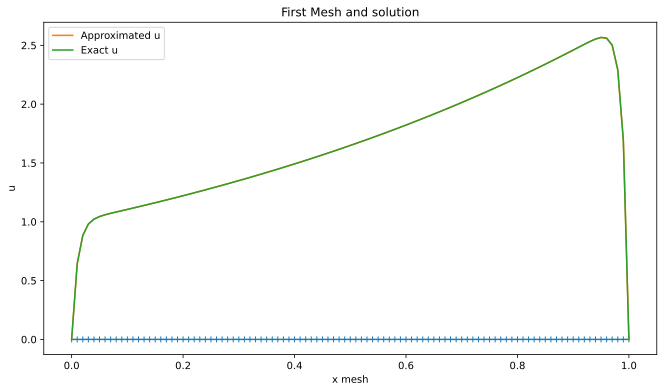

In [ ]:
# FIRST PHYSICAL SOLVE
##############################


u = TrialFunction(V)
v = TestFunction(V)


Jx = x_old.dx(0) #dx/dxi


# Set the bilinear and linear forms of the weak form
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
L = ( exp(x_old) ) * v * Jx * dx #transform dxi to dx


# Set the BC's
bcs = [DirichletBC(V, Constant(0), 1), DirichletBC(V, Constant(0), 2)]


# Solve
u = Function(V)
solve( a==L, u, bcs = bcs, solver_parameters = lu_params)

print()
print()



# Plot
permute_x = np.argsort(x_old.dat.data[:])

plt.plot(x_old.dat.data[permute_x], np.zeros_like(x_old.dat.data[permute_x]), marker = "|")
plt.plot(x_old.dat.data[permute_x], u.dat.data[permute_x], label = "Approximated u")
plt.plot(x_old.dat.data[permute_x], Function(V).interpolate(u_exact).dat.data[permute_x], label = "Exact u")
plt.title("First Mesh and solution")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()

print()
print()
print()

## Initial Alpha Tilda

In [ ]:
# FIND AN INITIAL ALPHA TILDA
#####################################################


alpha_tilda = Function(V_alpha)


# Find second derivative of u w.r.t x

# compute the derivatives of our u
u_pr = u.dx(0)
u_prpr = u_pr.dx(0)
x_prpr = Jx.dx(0)
du_dx = (1/Jx) * u_pr
du2_dx2 = ( u_prpr -  du_dx * x_prpr) * (( 1/Jx )**2)

# Set the RHS of the rho problem: 2*C_t
RHS = float(2.0) # 2*C_t evaluates to 2 for p=q=2 and m = 0,1

# Set an initial bisection interval as (a1=0, a2=0) to be updated
alpha1 = 0
alpha2 = 0

# Set our initial guess for alpha_tilda to be 1.0
alpha3 = 1.0

# Stopping criteria
maxit_alpha = 1000
iter = 0


# Loop to find search interval for alpha
while ((iter <= maxit_alpha) and (alpha1==0 or alpha2==0)) :

    iter += 1

    # Compute LHS as integral of rho
    inside_bit = 1 + (1/alpha3) * abs(du2_dx2)
    rho = inside_bit ** (exp_rho)
    LHS = float(assemble(rho * Jx * dx))

    # check is alpha guess is too small. If so, make it left endpoint and increase size
    if LHS > RHS:
      alpha1 = alpha3
      alpha3 = 2*alpha1

    # if alpha guess to too big, make it right endpoint and decrease size
    else:
      alpha2 = alpha3
      alpha3 = alpha2/2


# Hopefully we have (alpha1, alpha2) search interval. Lets check
if (alpha1==0 and alpha2==0):
  print("WARNING WE DID NOT FIND A SEARCH INTERVAL FOR ALPHA")
  print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


# Now we do bisection in this search interval to find alpha tilda
alpha3 = (alpha1 + alpha2)/2
inside_bit = 1 + (1/alpha3) * abs(du2_dx2)
rho = inside_bit ** (exp_rho)
LHS = float(assemble(rho * Jx * dx))
iter = 0

while ( (iter <= maxit_alpha) and ( abs(LHS - RHS) > 1e-6 )):

  iter += 1

  if (LHS - RHS) > 0:
    alpha1 = alpha3

  else:
    alpha2 = alpha3

  # update alpha3 as new midpoint
  alpha3 = (alpha1 + alpha2)/2

  # Update our LHS
  inside_bit = 1 + (1/alpha3) * abs(du2_dx2)
  rho = inside_bit ** (exp_rho)
  LHS = float(assemble(rho * Jx * dx))



# Did we find our alpha tilda??
if iter == maxit_alpha:
  print("WARNING WE DID NOT FIND AN ALPHA TILDA UNDER MAXITS")
  print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


# Set alpha tilda to be the final alpha3
alpha_tilda.interpolate(alpha3)



print("starting alpha_tilda is", float(alpha_tilda))
print()
print()


starting alpha_tilda is 7.5601806640625




## MP Iteration

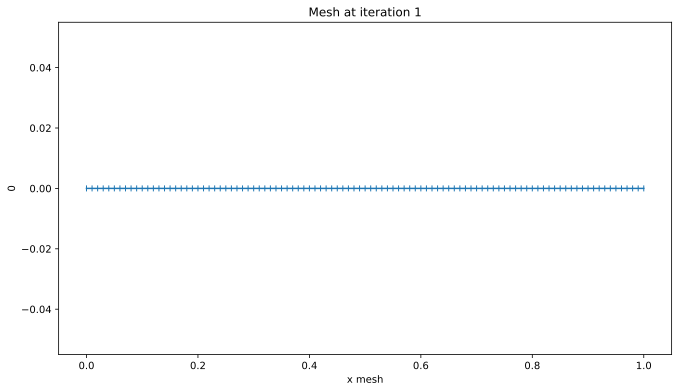

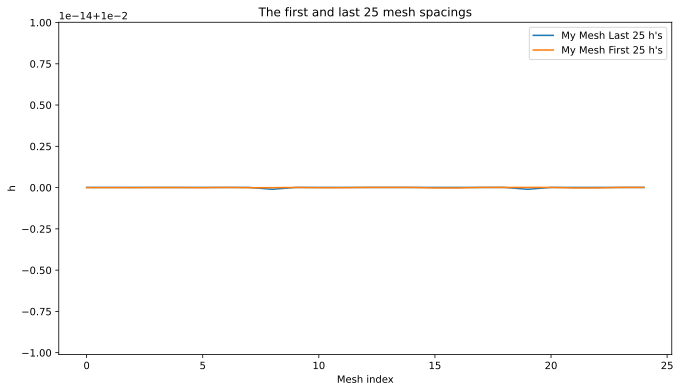





MP ITERATION NUMBER 1
__________________________________________________


mesh solve
  0 SNES Function norm 4.577148129115e+04
  1 SNES Function norm 1.183783679441e-11

physical solve
  0 SNES Function norm 1.987948630317e-01
  1 SNES Function norm 1.719602939773e-13

alpha solve
  0 SNES Function norm 3.249801713484e-03
  1 SNES Function norm 1.605250728912e-05
  2 SNES Function norm 3.882732323760e-10
  3 SNES Function norm 1.689529893307e-16

alpha_tilda =  7.510118860514274






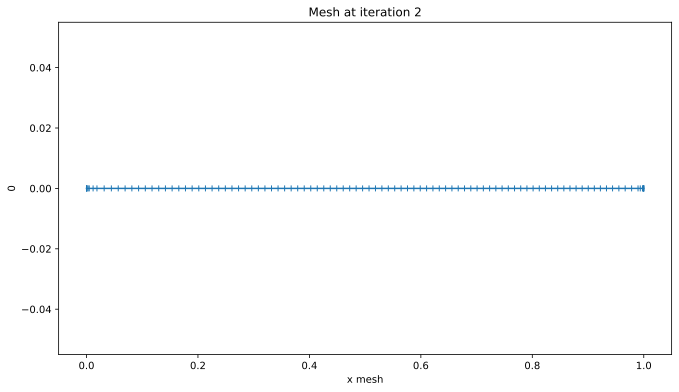

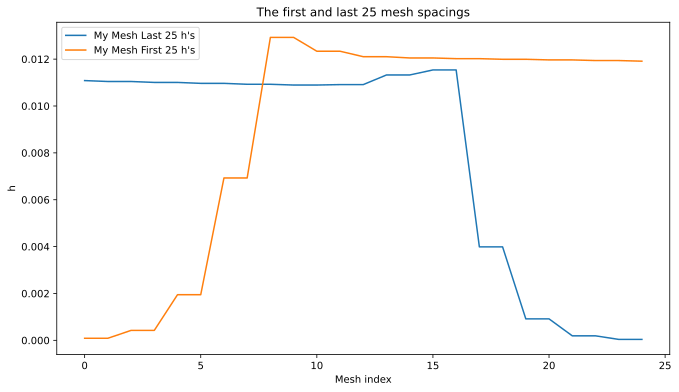





MP ITERATION NUMBER 2
__________________________________________________


mesh solve
  0 SNES Function norm 9.417604802273e+04
  1 SNES Function norm 5.907342005629e-11

physical solve
  0 SNES Function norm 2.133514139579e-01
  1 SNES Function norm 1.308858879603e-13

alpha solve
  0 SNES Function norm 4.892756572430e-03
  1 SNES Function norm 3.559405826508e-05
  2 SNES Function norm 1.907990662622e-09
  3 SNES Function norm 1.253909155960e-16

alpha_tilda =  7.585378867877817






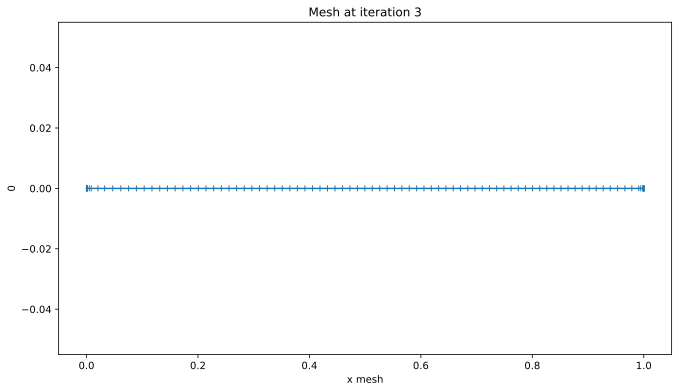

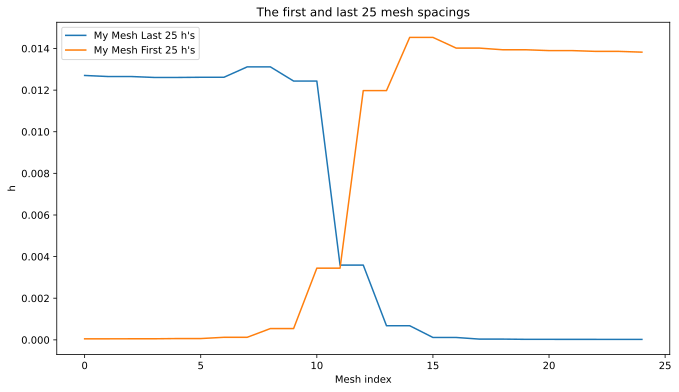





MP ITERATION NUMBER 3
__________________________________________________


mesh solve
  0 SNES Function norm 9.355758339559e+04
  1 SNES Function norm 8.834406753238e-11

physical solve
  0 SNES Function norm 2.302206806436e-01
  1 SNES Function norm 6.553721748877e-13

alpha solve
  0 SNES Function norm 1.763960827055e-02
  1 SNES Function norm 4.462581780319e-04
  2 SNES Function norm 2.985500785847e-07
  3 SNES Function norm 1.338546792788e-13

alpha_tilda =  7.8603034495449045






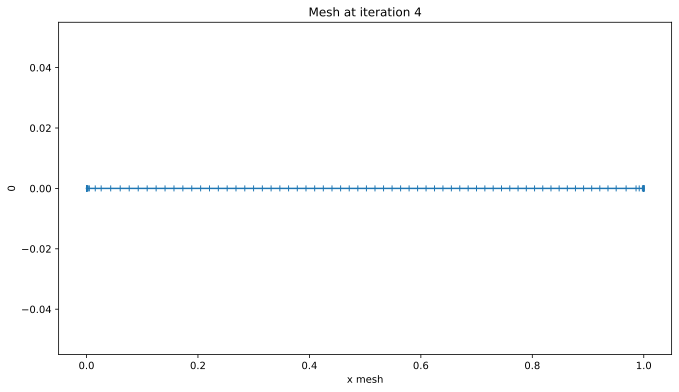

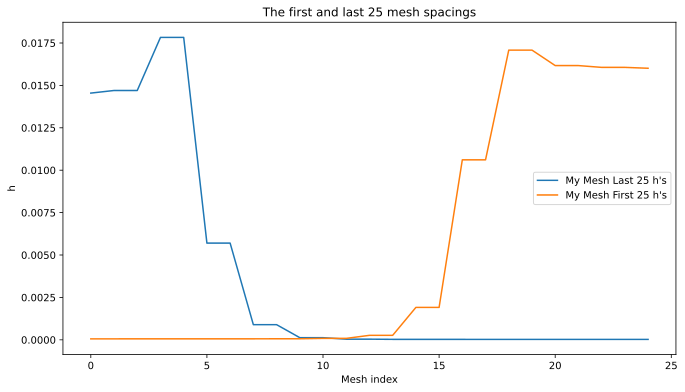





MP ITERATION NUMBER 4
__________________________________________________


mesh solve
  0 SNES Function norm 9.090511049823e+04
  1 SNES Function norm 1.110316051358e-10

physical solve
  0 SNES Function norm 2.468917800483e-01
  1 SNES Function norm 4.498516322811e-13

alpha solve
  0 SNES Function norm 4.164229114334e-03
  1 SNES Function norm 2.570723045418e-05
  2 SNES Function norm 9.903978443261e-10
  3 SNES Function norm 7.879126118720e-17

alpha_tilda =  7.926936144855553






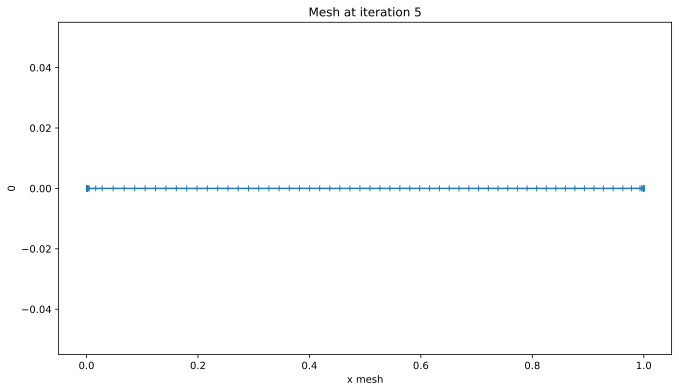

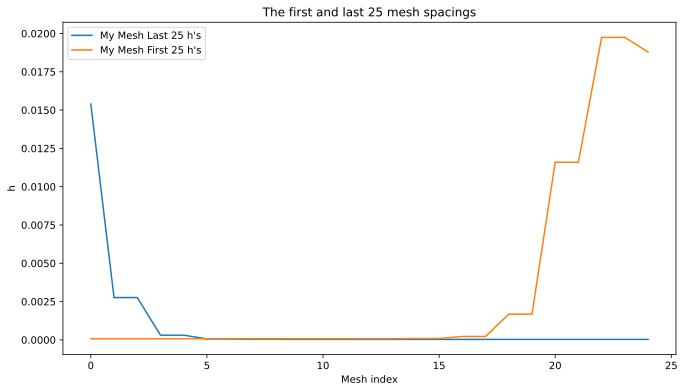





MP ITERATION NUMBER 5
__________________________________________________


mesh solve
  0 SNES Function norm 9.025609449227e+04
  1 SNES Function norm 8.880367548752e-11

physical solve
  0 SNES Function norm 2.662081514177e-01
  1 SNES Function norm 5.706178991876e-13

alpha solve
  0 SNES Function norm 7.813541330283e-03
  1 SNES Function norm 8.940506906482e-05
  2 SNES Function norm 1.194315465219e-08
  3 SNES Function norm 3.189122695976e-16

alpha_tilda =  8.053037860059609






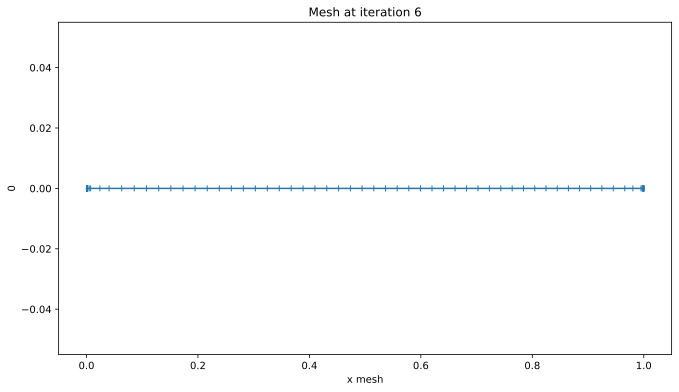

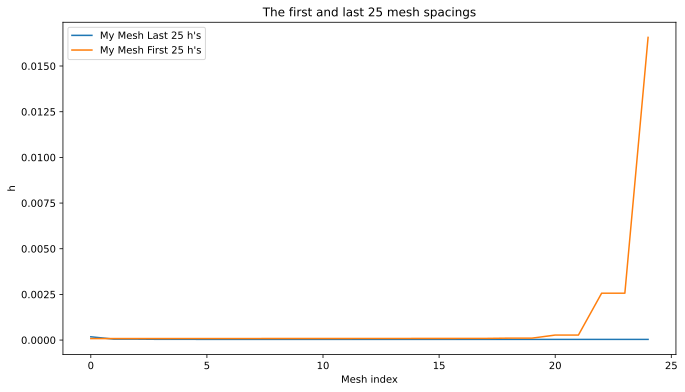





MP ITERATION NUMBER 6
__________________________________________________


mesh solve
  0 SNES Function norm 8.908386557165e+04
  1 SNES Function norm 1.298020015307e-10

physical solve
  0 SNES Function norm 2.882207790306e-01
  1 SNES Function norm 3.936566978305e-13

alpha solve
  0 SNES Function norm 1.939847992045e-02
  1 SNES Function norm 5.303879348732e-04
  2 SNES Function norm 4.159567046372e-07
  3 SNES Function norm 2.561517744299e-13

alpha_tilda =  8.37025373297565






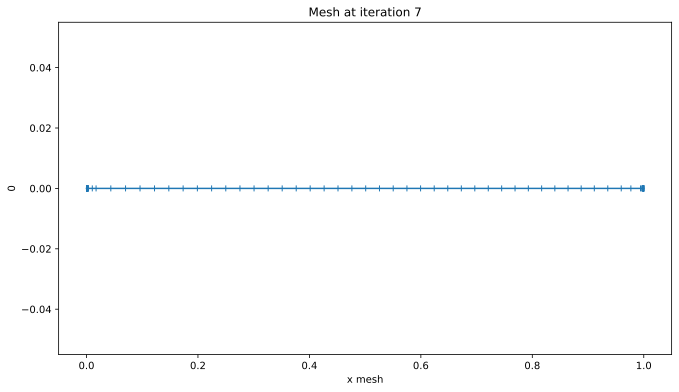

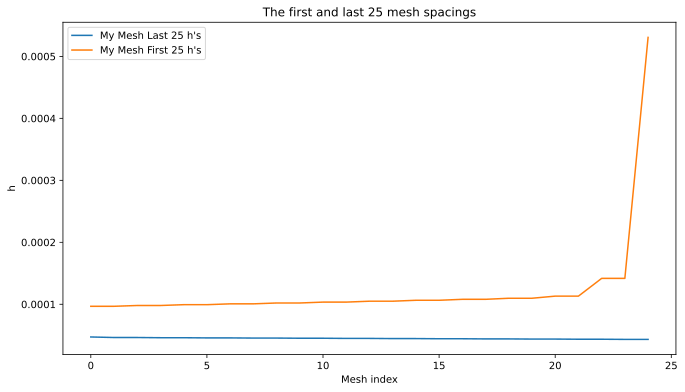





MP ITERATION NUMBER 7
__________________________________________________


mesh solve
  0 SNES Function norm 8.632410271983e+04
  1 SNES Function norm 1.162989899090e-10

physical solve
  0 SNES Function norm 3.155163941971e-01
  1 SNES Function norm 4.379660290098e-13

alpha solve
  0 SNES Function norm 2.108592805706e-02
  1 SNES Function norm 6.229294943390e-04
  2 SNES Function norm 5.725134925301e-07
  3 SNES Function norm 4.842513909476e-13

alpha_tilda =  8.729355619490127






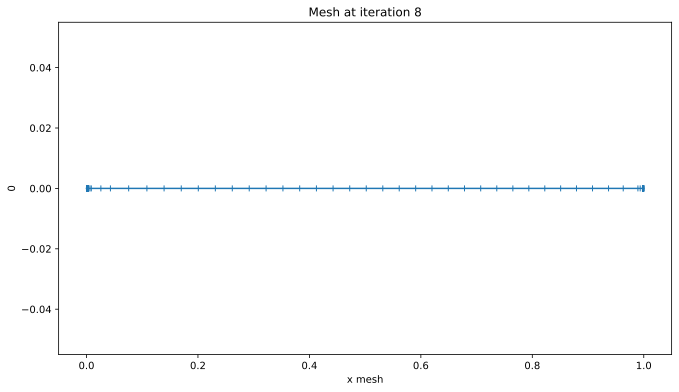

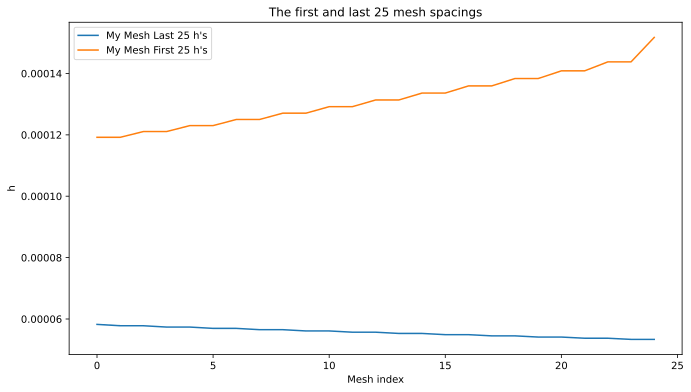





MP ITERATION NUMBER 8
__________________________________________________


mesh solve
  0 SNES Function norm 8.340375273813e+04
  1 SNES Function norm 1.417033491094e-10

physical solve
  0 SNES Function norm 3.469689724987e-01
  1 SNES Function norm 2.835387844842e-13

alpha solve
  0 SNES Function norm 2.785984241159e-02
  1 SNES Function norm 1.221378683983e-03
  2 SNES Function norm 2.171653989345e-06
  3 SNES Function norm 6.886956768747e-12

alpha_tilda =  8.254202031461576






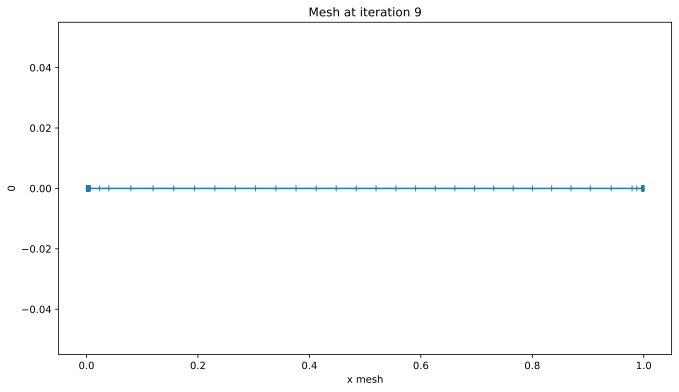

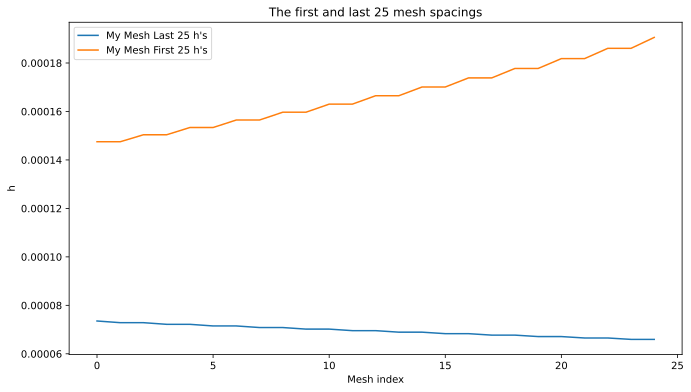





MP ITERATION NUMBER 9
__________________________________________________


mesh solve
  0 SNES Function norm 8.713719739726e+04
  1 SNES Function norm 1.179041181833e-10

physical solve
  0 SNES Function norm 3.814906749164e-01
  1 SNES Function norm 2.487826091969e-13

alpha solve
  0 SNES Function norm 3.369317096035e-02
  1 SNES Function norm 1.859936402463e-03
  2 SNES Function norm 5.138298094340e-06
  3 SNES Function norm 3.940732716146e-11

alpha_tilda =  7.70168178019331






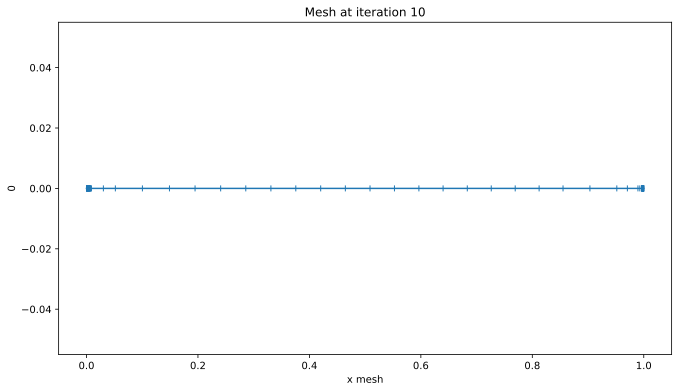

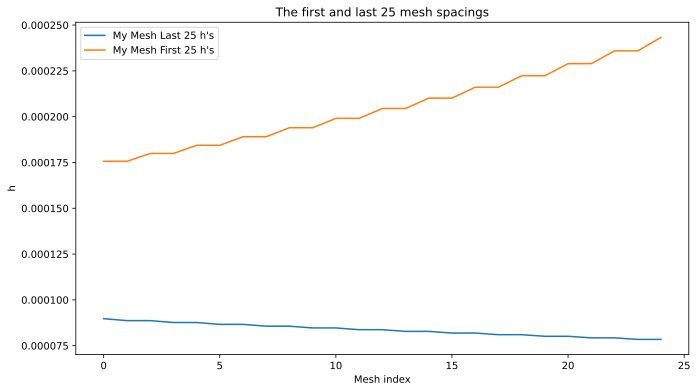





MP ITERATION NUMBER 10
__________________________________________________


mesh solve
  0 SNES Function norm 9.200872520747e+04
  1 SNES Function norm 1.460484739199e-10

physical solve
  0 SNES Function norm 4.173896880789e-01
  1 SNES Function norm 2.410009956902e-13

alpha solve
  0 SNES Function norm 6.005435730779e-02
  1 SNES Function norm 4.555848489669e-03
  2 SNES Function norm 2.991519666379e-05
  3 SNES Function norm 1.304887922207e-09
  4 SNES Function norm 3.585124471738e-17

alpha_tilda =  8.644440084150888






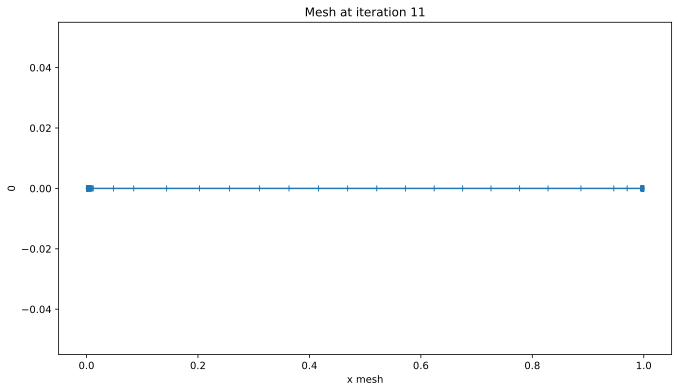

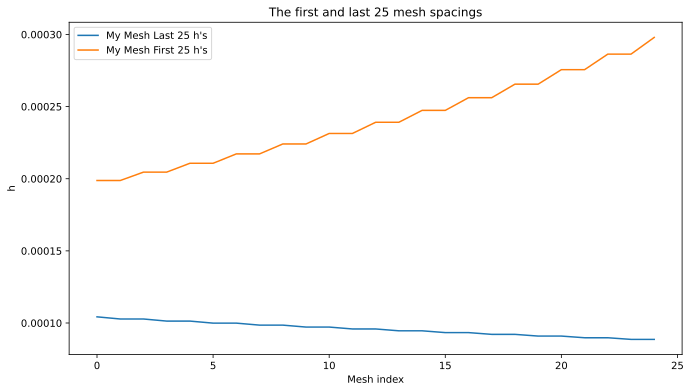





MP ITERATION NUMBER 11
__________________________________________________


mesh solve
  0 SNES Function norm 8.380791481484e+04
  1 SNES Function norm 1.403590468723e-10

physical solve
  0 SNES Function norm 4.577717123404e-01
  1 SNES Function norm 1.457775344367e-13

alpha solve
  0 SNES Function norm 4.014417702801e-02
  1 SNES Function norm 2.635188364987e-03
  2 SNES Function norm 1.010297066333e-05
  3 SNES Function norm 1.495084561231e-10

alpha_tilda =  7.966847569061048






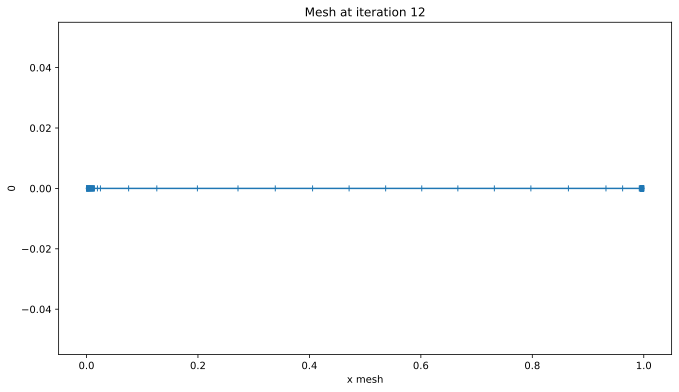

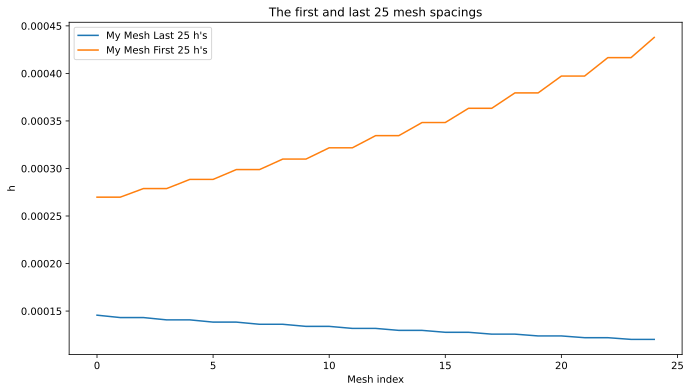





MP ITERATION NUMBER 12
__________________________________________________


mesh solve
  0 SNES Function norm 8.922790333898e+04
  1 SNES Function norm 1.123726883565e-10

physical solve
  0 SNES Function norm 5.051804137195e-01
  1 SNES Function norm 1.478111405957e-13

alpha solve
  0 SNES Function norm 2.423480217167e-04
  1 SNES Function norm 8.639027517869e-08
  2 SNES Function norm 1.094334140635e-14

alpha_tilda =  7.970736324134998






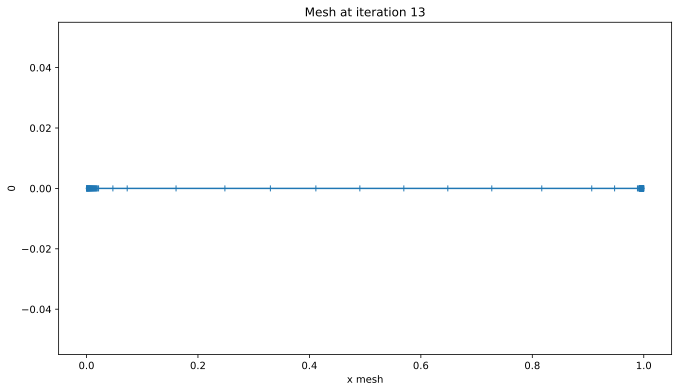

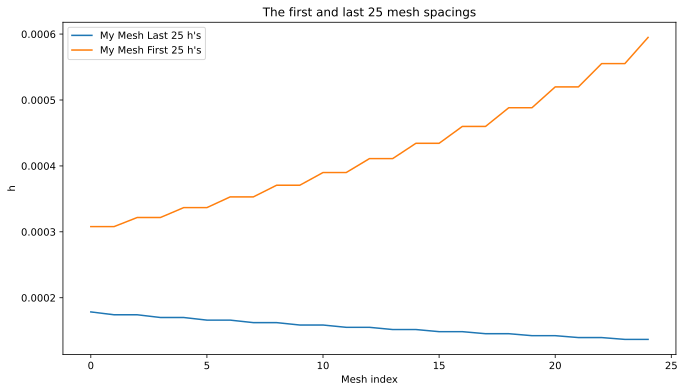





MP ITERATION NUMBER 13
__________________________________________________


mesh solve
  0 SNES Function norm 8.907302627477e+04
  1 SNES Function norm 1.221406375925e-10

physical solve
  0 SNES Function norm 5.476256101305e-01
  1 SNES Function norm 8.001220694556e-14

alpha solve
  0 SNES Function norm 9.278695813324e-02
  1 SNES Function norm 1.669887594567e-02
  2 SNES Function norm 3.933070882331e-04
  3 SNES Function norm 2.273609259497e-07
  4 SNES Function norm 7.616808617871e-14

alpha_tilda =  6.559508938149499






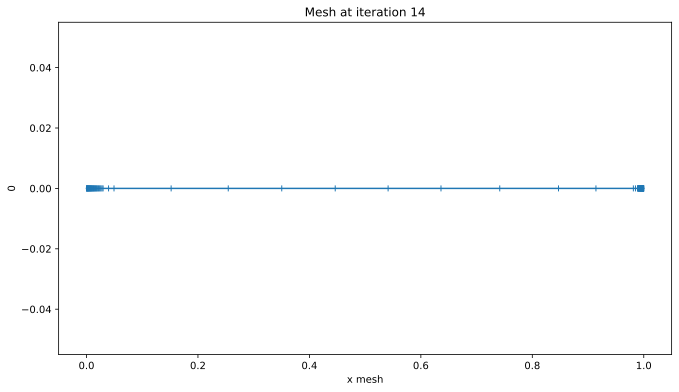

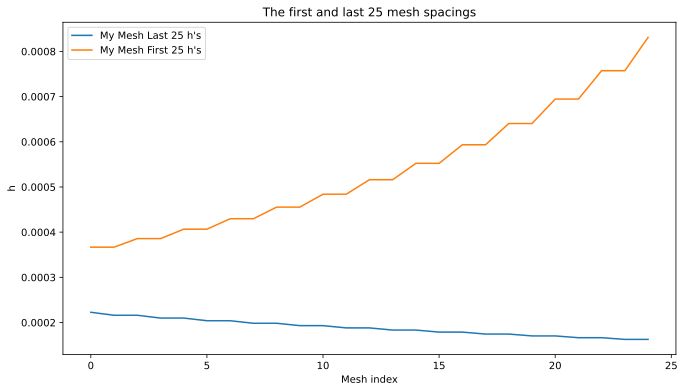





MP ITERATION NUMBER 14
__________________________________________________


mesh solve
  0 SNES Function norm 1.038969692693e+05
  1 SNES Function norm 1.412698215595e-10

physical solve
  0 SNES Function norm 5.838453713173e-01
  1 SNES Function norm 1.155050985175e-13

alpha solve
  0 SNES Function norm 3.146703845028e-02
  1 SNES Function norm 1.677948819764e-03
  2 SNES Function norm 4.343420234559e-06
  3 SNES Function norm 2.923527301123e-11

alpha_tilda =  6.131578075496838






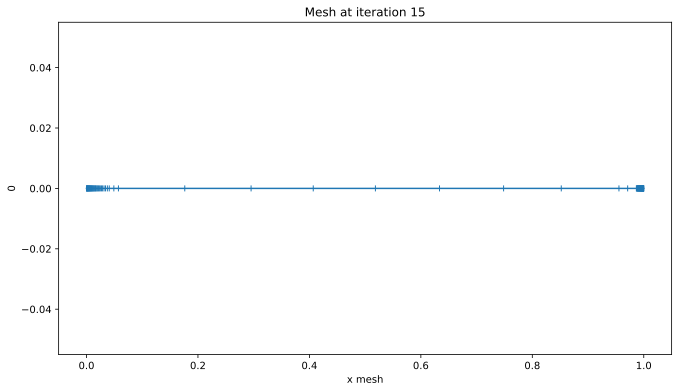

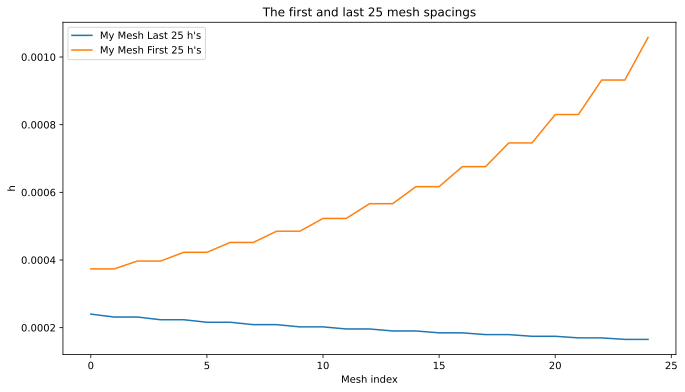





MP ITERATION NUMBER 15
__________________________________________________


mesh solve
  0 SNES Function norm 1.096519260823e+05
  1 SNES Function norm 1.235681545493e-10

physical solve
  0 SNES Function norm 6.025561331181e-01
  1 SNES Function norm 1.058125874412e-13

alpha solve
  0 SNES Function norm 1.540967583528e-03
  1 SNES Function norm 3.327951845894e-06
  2 SNES Function norm 1.558181522340e-11
  3 SNES Function norm 1.643488076314e-17

alpha_tilda =  6.149436731390366






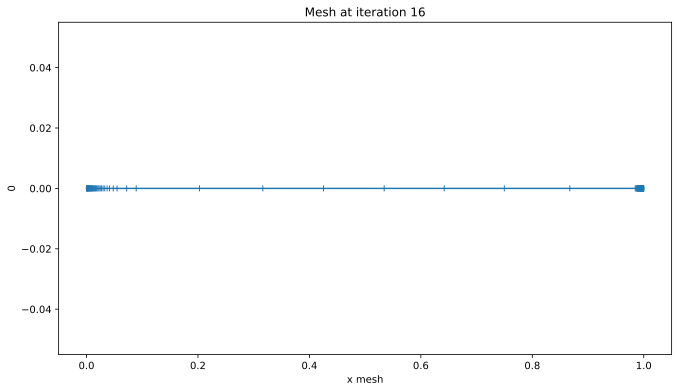

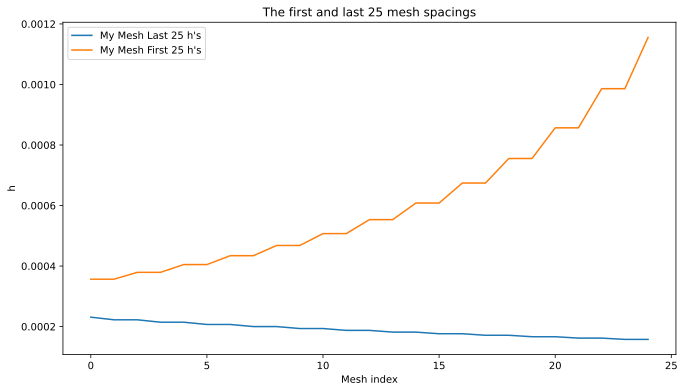





MP ITERATION NUMBER 16
__________________________________________________


mesh solve
  0 SNES Function norm 1.094008983320e+05
  1 SNES Function norm 1.341801645874e-10

physical solve
  0 SNES Function norm 5.669516470960e-01
  1 SNES Function norm 9.555759774161e-14

alpha solve
  0 SNES Function norm 9.823119478950e-02
  1 SNES Function norm 1.151280392715e-02
  2 SNES Function norm 1.930098803971e-04
  3 SNES Function norm 5.586183426642e-08
  4 SNES Function norm 4.738899204389e-15

alpha_tilda =  7.448023940970589






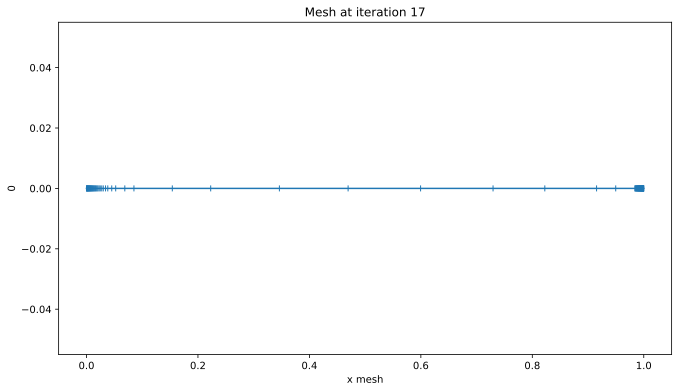

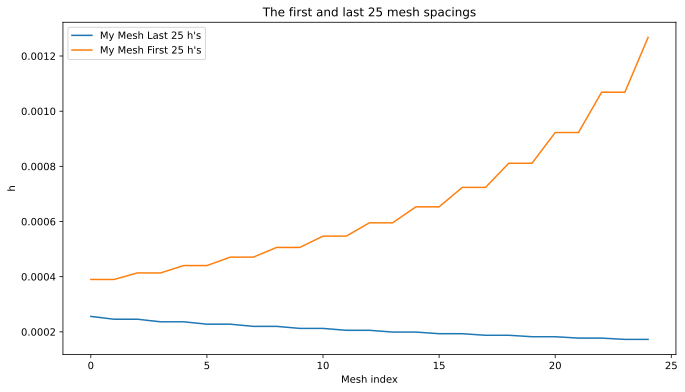





MP ITERATION NUMBER 17
__________________________________________________


mesh solve
  0 SNES Function norm 9.379187061200e+04
  1 SNES Function norm 1.100940055759e-10

physical solve
  0 SNES Function norm 5.585669677857e-01
  1 SNES Function norm 1.228130523195e-13

alpha solve
  0 SNES Function norm 1.034435808365e-01
  1 SNES Function norm 2.151354242337e-02
  2 SNES Function norm 6.424576421953e-04
  3 SNES Function norm 6.039523940054e-07
  4 SNES Function norm 5.345460012153e-13

alpha_tilda =  6.004515447389427






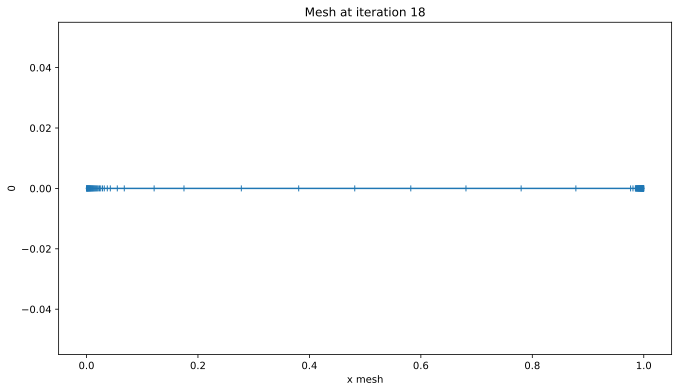

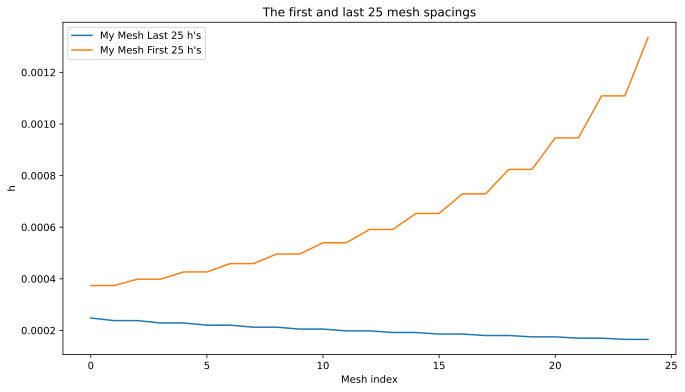





MP ITERATION NUMBER 18
__________________________________________________


mesh solve
  0 SNES Function norm 1.114987383945e+05
  1 SNES Function norm 1.205286779474e-10

physical solve
  0 SNES Function norm 5.497464166090e-01
  1 SNES Function norm 1.517218851706e-13

alpha solve
  0 SNES Function norm 1.152900223859e-01
  1 SNES Function norm 1.525741518910e-02
  2 SNES Function norm 3.341458732917e-04
  3 SNES Function norm 1.665213494845e-07
  4 SNES Function norm 4.132804424429e-14

alpha_tilda =  7.500227059252445






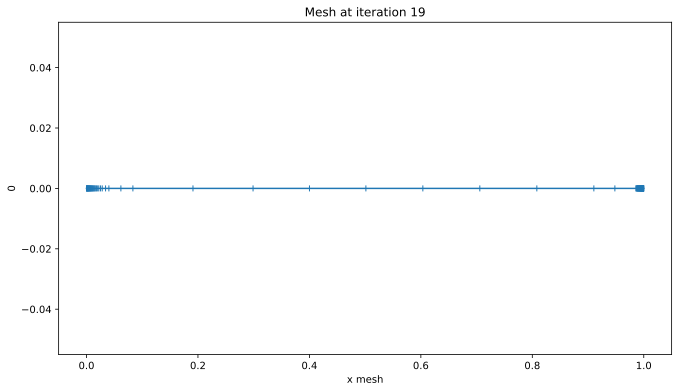

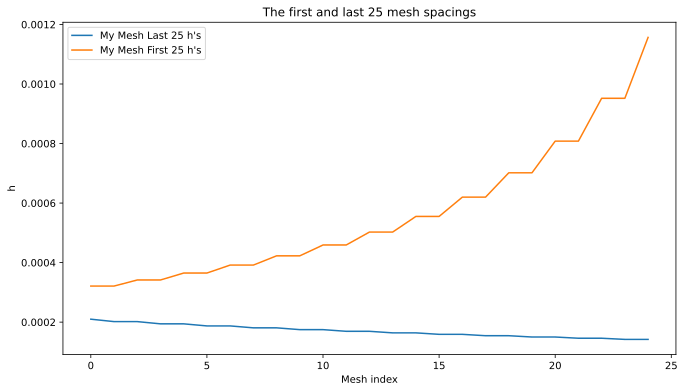





MP ITERATION NUMBER 19
__________________________________________________


mesh solve
  0 SNES Function norm 9.349440438933e+04
  1 SNES Function norm 1.249296169900e-10

physical solve
  0 SNES Function norm 5.813693759691e-01
  1 SNES Function norm 9.752763216259e-14

alpha solve
  0 SNES Function norm 1.278200289867e-01
  1 SNES Function norm 3.632970342467e-02
  2 SNES Function norm 1.775078931426e-03
  3 SNES Function norm 4.618463399830e-06
  4 SNES Function norm 3.140994757139e-11

alpha_tilda =  5.718710064410991






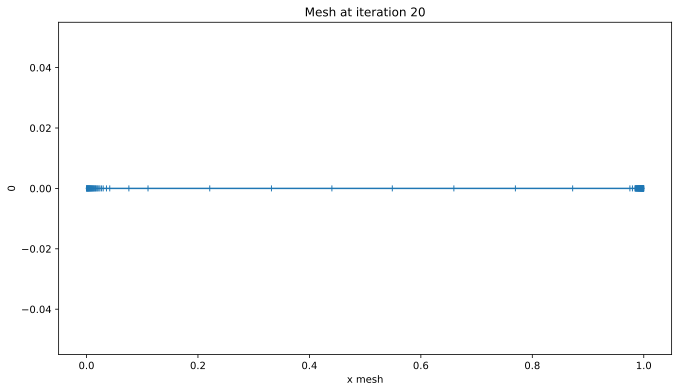

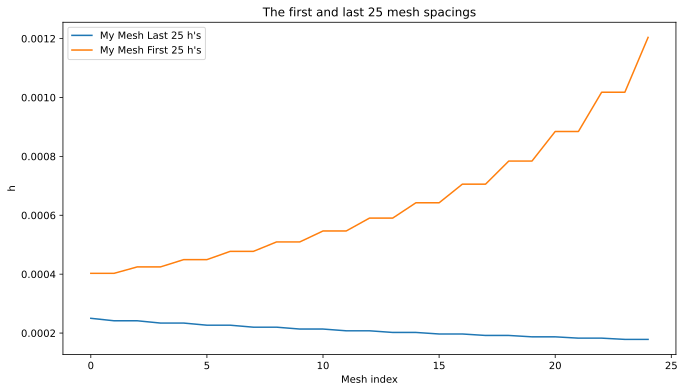





MP ITERATION NUMBER 20
__________________________________________________


mesh solve
  0 SNES Function norm 1.158174837812e+05
  1 SNES Function norm 1.256201750618e-10

physical solve
  0 SNES Function norm 5.892705037453e-01
  1 SNES Function norm 9.070532914445e-14

alpha solve
  0 SNES Function norm 7.599708078378e-02
  1 SNES Function norm 7.222073765268e-03
  2 SNES Function norm 7.671138345304e-05
  3 SNES Function norm 8.816754627720e-09
  4 SNES Function norm 4.973421811352e-17

alpha_tilda =  6.651124286678264




In [ ]:
# MP ITERATION
###############################################################

MPIter = 20

for i in range(MPIter):


  print()
  print()


  # plot the mesh
  plt.plot(x_old.dat.data[permute_x], np.zeros_like(x_old.dat.data[permute_x]), marker = "|")
  plt.title("Mesh at iteration " + str(i+1))
  plt.xlabel("x mesh")
  plt.ylabel("0")
  plt.show()
  print()
  print()

  # Plot the mesh spacing we have
  plt.plot(np.diff(x_old.dat.data[permute_x])[-25:], label = "My Mesh Last 25 h's")
  plt.plot(np.diff(x_old.dat.data[permute_x])[0:25], label = "My Mesh First 25 h's")
  plt.title("The first and last 25 mesh spacings")
  plt.xlabel("Mesh index")
  plt.ylabel("h")
  plt.legend()
  plt.show()

  print()
  print()
  print()
  print()


  print('MP ITERATION NUMBER', i+1)
  print("_"*50)
  print()
  print()


  # x_old jacobian
  jacobx = x_old.dx(0) #dx/dxi

  # compute the derivatives of our u
  u_pr_lin = u.dx(0)
  u_prpr_lin = u_pr_lin.dx(0)
  x_prpr_lin = jacobx.dx(0)
  du_dx_lin = (1/jacobx) * u_pr_lin
  du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)

  # compute the Hessian M using computed alpha tilda

  # Compute alpha using alpha tilda
  alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
  alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
  # Now compute M
  inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
  M_lin = inside_bit_lin ** (exp_M)



  # MESH SOLVE

  print('mesh solve')

  # set solution and test function
  new_x = TrialFunction(V)
  vm = TestFunction(V)

  # jacobian
  Jm = new_x.dx(0) #dx/dxi

  # v'
  v_pr_term = (vm).dx(0)

  # the lhs of the eqn
  am = (M_lin * Jm * v_pr_term) * dx
  Lm = (Function(V)*v)*dx

  # bc's
  bc0 = DirichletBC(V, Constant(0), 1)
  bc1 = DirichletBC(V, Constant(1), 2)
  bcs = [bc0, bc1]


  # Solve
  new_x = Function(V)
  solve( am == Lm, new_x, bcs = bcs, solver_parameters = lu_params)

  # update our xold
  x_old.dat.data[:] = new_x.dat.data[:]



  # PHYSICAL SOLVE ON NEW MESH

  print()
  print('physical solve')


  u = TrialFunction(V)
  v = TestFunction(V)
  Jx = x_old.dx(0) # now is our new_x


  # Set the bilinear and linear forms of the weak form
  u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
  v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
  a = ((epsilon**2) * (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
  L = ( exp(x_old) ) * v * Jx * dx #transform dxi to dx


  # Set the BC's
  bcs = [DirichletBC(V, Constant(0), 1), DirichletBC(V, Constant(0), 2)]


  # Solve
  u = Function(V)
  solve( a==L, u, bcs = bcs, solver_parameters = lu_params)



  print()
  print('alpha solve')

bvcxxd


  # Print alpha tilda
  print()
  print('alpha_tilda = ', float(alpha_tilda))
  print()
  print()




## Plot Results

In [ ]:
# Order the final mesh

permute_x = np.argsort(x_old.dat.data[:])

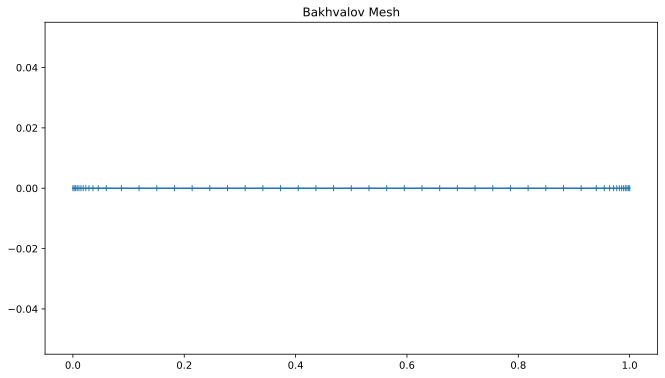

In [ ]:
# Form the 1D B mesh to compare


epsilon = 0.01
q = 1/4
sigma = 2
b = 1/sqrt(2)
a = sigma/b
tau = q-a*epsilon
error = 1


while error>1e-14:

  g2 = a*epsilon*(0.5-tau)-(0.5+a*epsilon*np.log(1-tau/q))*(q-tau)
  g2_tau = 1 + a*epsilon*np.log(1-tau/q)
  tau_new =tau-g2/g2_tau
  error = abs(tau-tau_new)
  tau=tau_new


if tau>0:

  phi = -a*epsilon*np.log(1-tau/q)
  phi_tau = a*epsilon/(q-tau)
  x_uni = np.linspace(0, 1, N+1)
  x_b = np.zeros(N+1)

  for i in range(1,int(N/2+1)):
    if x_uni[i]<tau:
      x_b[i] = -a*epsilon*np.log(1-x_uni[i]/q)
    else:
      x_b[i] = -a*epsilon*np.log(1-tau/q)+(x_uni[i]-tau)*phi_tau

  for i in range(int(N/2+1),N+1):
    x_b[i] = 1-x_b[N-i]


else:

  x_b = np.linspace(0, 1, N+1)


# Plot the result
plt.plot(x_b, [0 for i in range(N+1)], marker = "|")
plt.title('Bakhvalov Mesh')
plt.show()

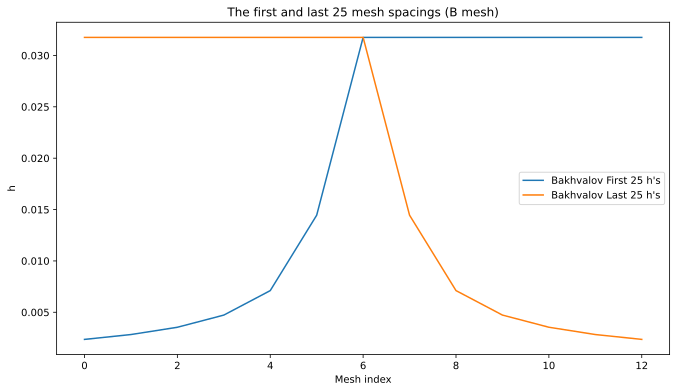

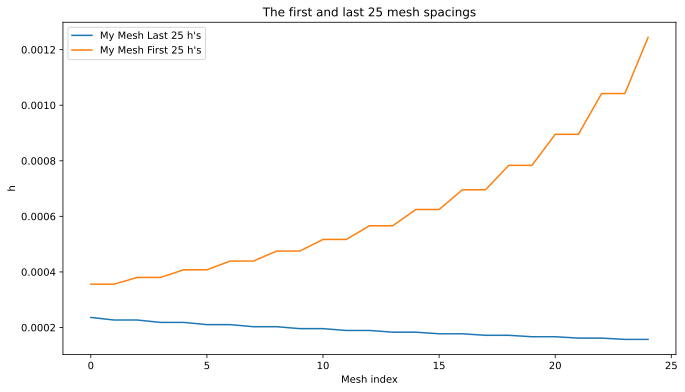

In [ ]:
# Plotting mesh differences
plt.plot(np.diff(x_b)[0:25:2], label = "Bakhvalov First 25 h's")
plt.plot(np.diff(x_b)[-25::2], label = "Bakhvalov Last 25 h's")
plt.title("The first and last 25 mesh spacings (B mesh)")
plt.xlabel("Mesh index")
plt.ylabel("h")
plt.legend()
plt.show()

print()
print()

plt.plot(np.diff(x_old.dat.data[permute_x])[-25:], label = "My Mesh Last 25 h's")
plt.plot(np.diff(x_old.dat.data[permute_x])[0:25], label = "My Mesh First 25 h's")
# plt.plot(np.diff(x_b)[0:25], label = "Bakhvalov First 25 h's")
# plt.plot(np.diff(x_b)[-25:], label = "Bakhvalov Last 25 h's")
plt.title("The first and last 25 mesh spacings")
plt.xlabel("Mesh index")
plt.ylabel("h")
plt.legend()
plt.show()

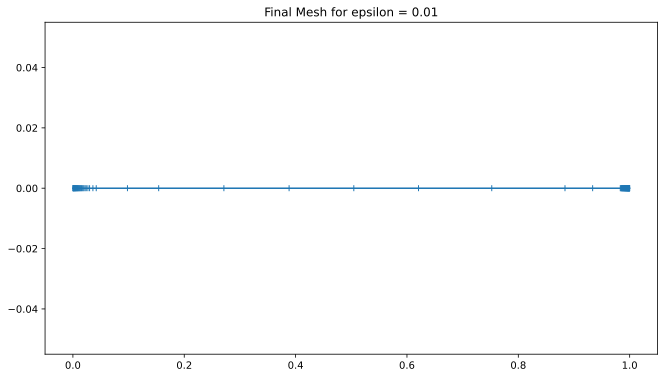

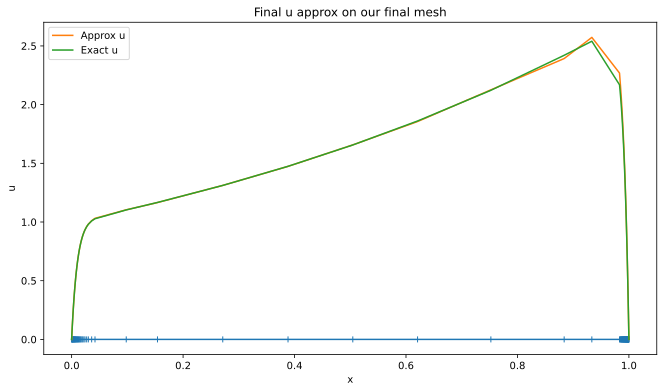



final alpha_tilda =  6.651124286678264


In [ ]:
# Exact solution

# Set exact solution
top = (1 - exp(1 - 1/epsilon))*exp(-x_old/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x_old-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x_old)/(epsilon**2 - 1)
u_exact = top/bottom - sub


# print final mesh
plt.plot(x_old.dat.data[permute_x], [0 for i in range(len(x_old.dat.data[permute_x]))], marker = "|")
plt.title("Final Mesh for epsilon = " + str(float(epsilon)))
plt.show()
print()
print()


# print u against this mesh
plt.plot(x_old.dat.data[permute_x], [0 for i in range(len(x_old.dat.data[permute_x]))], marker = "|")
plt.plot(x_old.dat.data[permute_x], u.dat.data[permute_x], label = "Approx u")
plt.plot(x_old.dat.data[permute_x], Function(V).interpolate(u_exact).dat.data[permute_x], label = "Exact u")
plt.title("Final u approx on our final mesh")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()


# final alpha value

print("final alpha_tilda = ", alpha_tilda.dat.data[:][0])